# Bayesian Optimization

Imagine you need to find the best settings for a complex system – perhaps tuning the hyperparameters of a deep learning model, optimizing the design of an experiment, or finding the ideal parameters for a simulation. Often, evaluating the system with a given set of parameters (i.e., running the experiment or training the model) is expensive, time-consuming, or resource-intensive. How can you find the optimal settings without performing an exhaustive search?

This is where **Bayesian Optimization (BO)** comes in. It's a powerful, sequential strategy designed specifically for the **global optimization of black-box functions**. These are functions where:

1.  We don't know the underlying mathematical form (it's a "black box").
2.  Evaluating the function (getting an output `y` for an input `x`) is costly.
3.  We often cannot compute derivatives (gradients).
4.  The observations might be noisy (the output `y` can vary even for the same input `x`).

BO tackles this challenge by intelligently choosing the next point to evaluate, aiming to find the optimum (maximum or minimum) in as few evaluations as possible.

### Core Components

Bayesian Optimization cleverly balances exploring unknown parts of the search space and exploiting areas known to yield good results. It does this using two main components:

1.  **A Probabilistic Surrogate Model:** This model approximates the unknown objective function based on the points observed so far. It also provides uncertainty estimates about the function's behavior in unexplored regions. Gaussian Processes (GPs) are the most common choice for this surrogate model due to their flexibility and inherent uncertainty quantification.
2.  **An Acquisition Function:** This function uses the surrogate model's predictions (mean and uncertainty) to determine the 'utility' of evaluating any given point in the search space. It guides the search by suggesting the point that is most likely to lead to an improvement, considering both the predicted performance and the uncertainty. Examples include Expected Improvement (EI) and Upper Confidence Bound (UCB).

### The Iterative Process

The BO algorithm works iteratively:

1.  **Observe:** Evaluate the black-box function at one or more points chosen by the acquisition function.
2.  **Update:** Update the surrogate model (e.g., the Gaussian Process) using all the data collected so far (inputs and their observed outputs).
3.  **Select:** Optimize the acquisition function (which is cheap to evaluate) over the search space to find the most promising point(s) to evaluate next.
4.  **Repeat:** Continue this cycle until a stopping criterion is met (e.g., budget of function evaluations exhausted, desired performance level reached).


### Recommended reading:
1. [A Tutorial on Bayesian Optimization](https://arxiv.org/pdf/1807.02811)
1. [BayesOpt docs]((https://bayesian-optimization.github.io/BayesianOptimization/2.0.3/))
1. [Exploring Bayesian Optimization](https://distill.pub/2020/bayesian-optimization/)
1. [Acquisition functions in Bayesian Optimization](https://ekamperi.github.io/machine%20learning/2021/06/11/acquisition-functions.html)
1. [A Visual Exploration of Gaussian Processes](https://distill.pub/2019/visual-exploration-gaussian-processes/)
1. [Practical Bayesian Optimization of Machine Learning Algorithms](https://arxiv.org/abs/1206.2944)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from bayes_opt import BayesianOptimization
from bayes_opt import acquisition

# Set random seed for reproducibility
np.random.seed(42)

### Define and visualize the target function
First, we'll create a synthetic objective function to optimize. This specific function has three peaks (at x=0, x≈2 and x≈6) and is a toy example.

$$f(x) = e^{-(x - 2)^2} + e^{-\frac{(x - 6)^2}{10}} + \frac{1}{x^2 + 1}$$

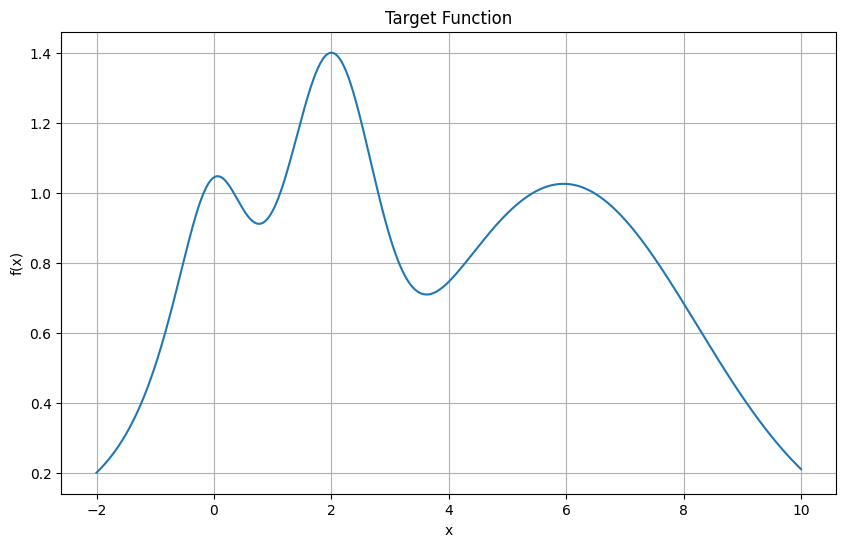

In [3]:
def target_function(x):
    """Our example target function to be optimized"""
    return np.exp(-((x - 2) ** 2)) + np.exp(-((x - 6) ** 2) / 10) + 1 / (x ** 2 + 1)


x = np.linspace(-2, 10, 1000)
y = target_function(x)

plt.figure(figsize=(10, 6))
plt.plot(x, y)
plt.grid(True)
plt.title("Target Function")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.show()

### Define visualization functions
These helper functions will visualize the Gaussian Process model
and acquisition function at each step of the optimization process.
They help us understand how the model evolves as more observations are made.

In [4]:
def posterior(optimizer, grid):
    """Get posterior mean and standard deviation from GP model"""
    mu, sigma = optimizer._gp.predict(grid, return_std=True)
    return mu, sigma


def plot_gp(optimizer, x, y, save_path=None):
    """Plot the Gaussian Process model, observations, and acquisition function"""
    fig = plt.figure(figsize=(16, 10))
    steps = len(optimizer.space)
    fig.suptitle(
        f"Gaussian Process and Utility Function After {steps} Steps",
        fontsize=30,
    )

    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
    axis = plt.subplot(gs[0])
    acq = plt.subplot(gs[1])

    x_obs = np.array([[res["params"]["x"]] for res in optimizer.res])
    y_obs = np.array([res["target"] for res in optimizer.res])

    optimizer.acquisition_function._fit_gp(optimizer._gp, optimizer._space)
    mu, sigma = posterior(optimizer, x)

    axis.plot(x, y, linewidth=3, label="Target")
    axis.plot(
        x_obs.flatten(), y_obs, "D", markersize=8, label="Observations", color="r"
    )
    axis.plot(x, mu, "--", color="k", label="Prediction")

    axis.fill(
        np.concatenate([x, x[::-1]]),
        np.concatenate([mu - 1.9600 * sigma, (mu + 1.9600 * sigma)[::-1]]),
        alpha=0.6,
        fc="c",
        ec="None",
        label="95% confidence interval",
    )

    axis.set_xlim((-2, 10))
    axis.set_ylim((None, None))
    axis.set_ylabel("f(x)", fontdict={"size": 20})
    axis.set_xlabel("x", fontdict={"size": 20})

    utility_function = optimizer.acquisition_function
    utility = -1 * utility_function._get_acq(gp=optimizer._gp)(x)
    x_flat = x.flatten()

    acq.plot(x_flat, utility, label="Utility Function", color="purple")
    acq.plot(
        x_flat[np.argmax(utility)],
        np.max(utility),
        "*",
        markersize=15,
        label="Next Best Guess",
        markerfacecolor="gold",
        markeredgecolor="k",
        markeredgewidth=1,
    )
    acq.set_xlim((-2, 10))
    acq.set_ylabel("Utility", fontdict={"size": 20})
    acq.set_xlabel("x", fontdict={"size": 20})

    axis.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.0)
    acq.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.0)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
        plt.close()
    else:
        plt.show()

    return fig

We'll now see Bayesian Optimization in action, step by step.
At each step, observe:
1. How the GP model (dashed line) is updated
2. How the confidence interval (light blue area) changes
3. How the acquisition function (purple line) guides the next sample
4. Where the next sample point (gold star) is placed

|   iter    |  target   |     x     |
-------------------------------------
| 1         | 0.8198    | 3.109     |
| 2         | 0.746     | 7.775     |

Step 0: Initial random points


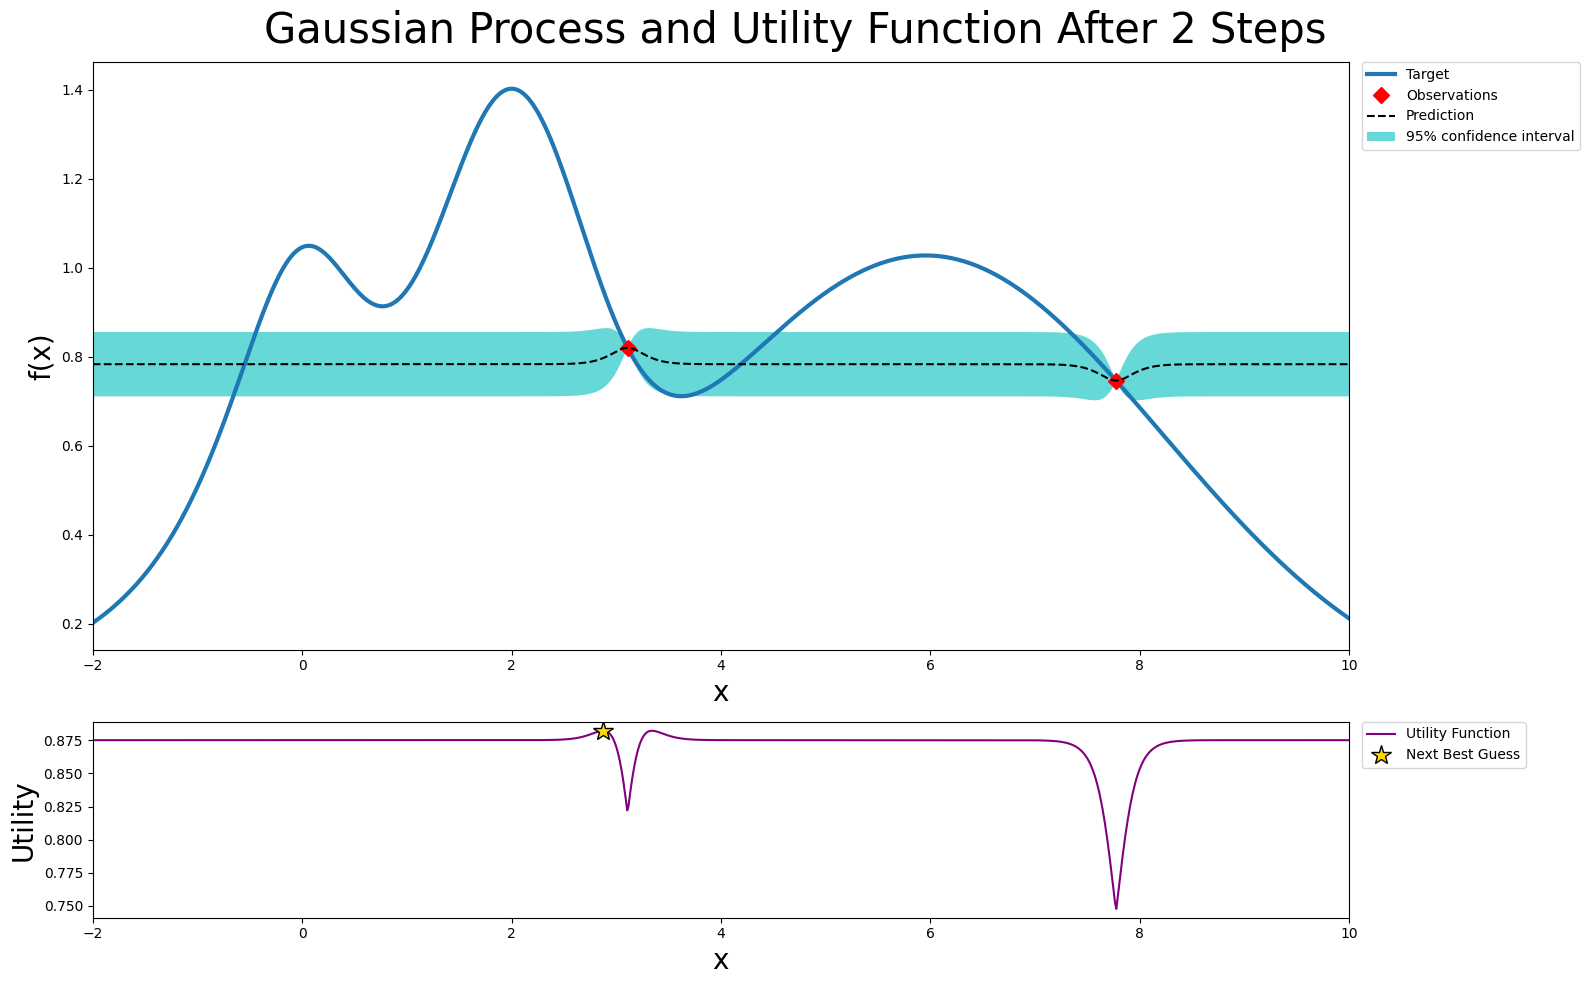

|   iter    |  target   |     x     |
-------------------------------------
| 3         | 0.8197    | 3.109     |

Step 1: Added a new observation


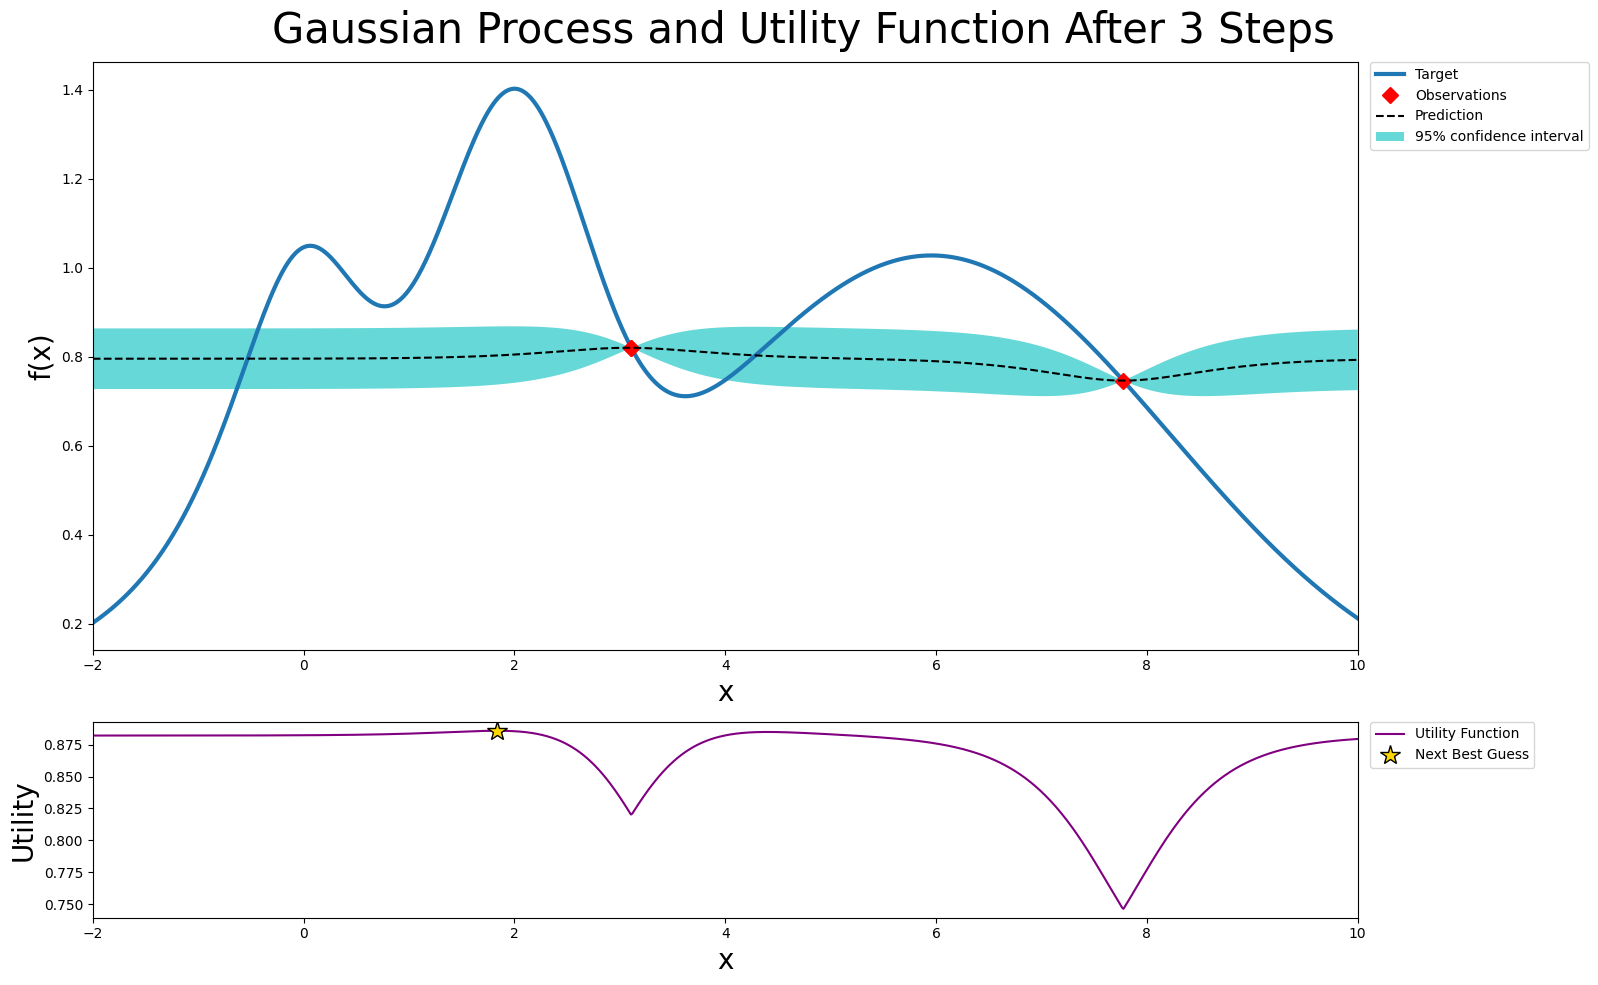

|   iter    |  target   |     x     |
-------------------------------------
| 4         | 1.378     | 1.832     |

Step 2: Added a new observation


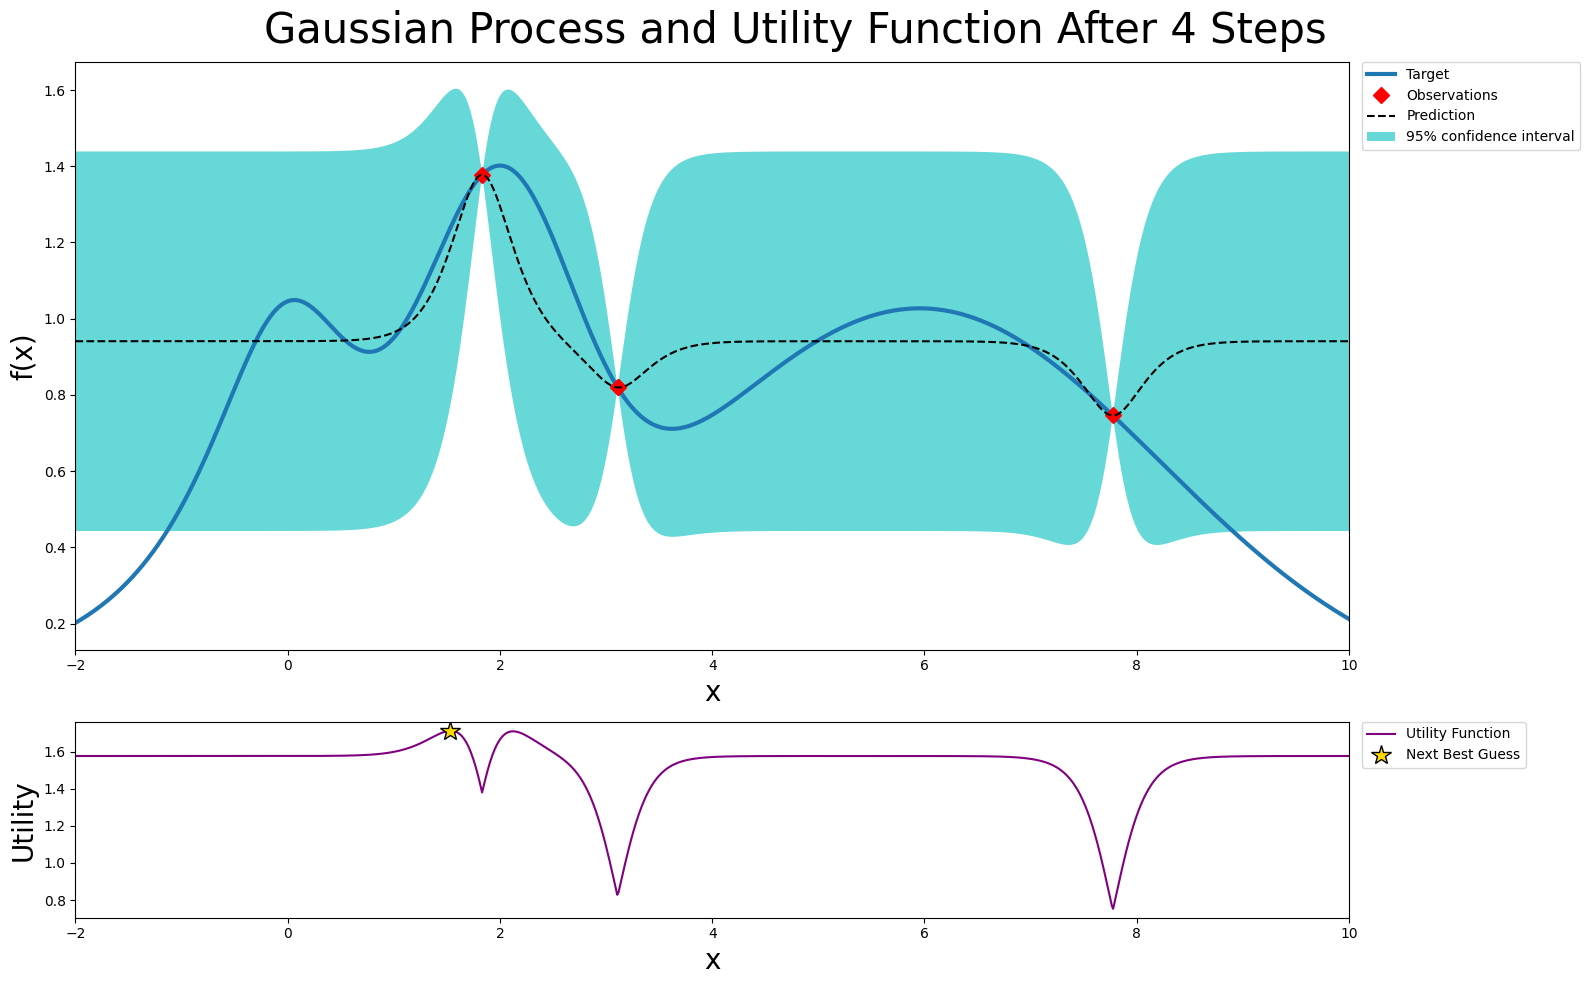

|   iter    |  target   |     x     |
-------------------------------------
| 5         | 1.24      | 1.536     |

Step 3: Added a new observation


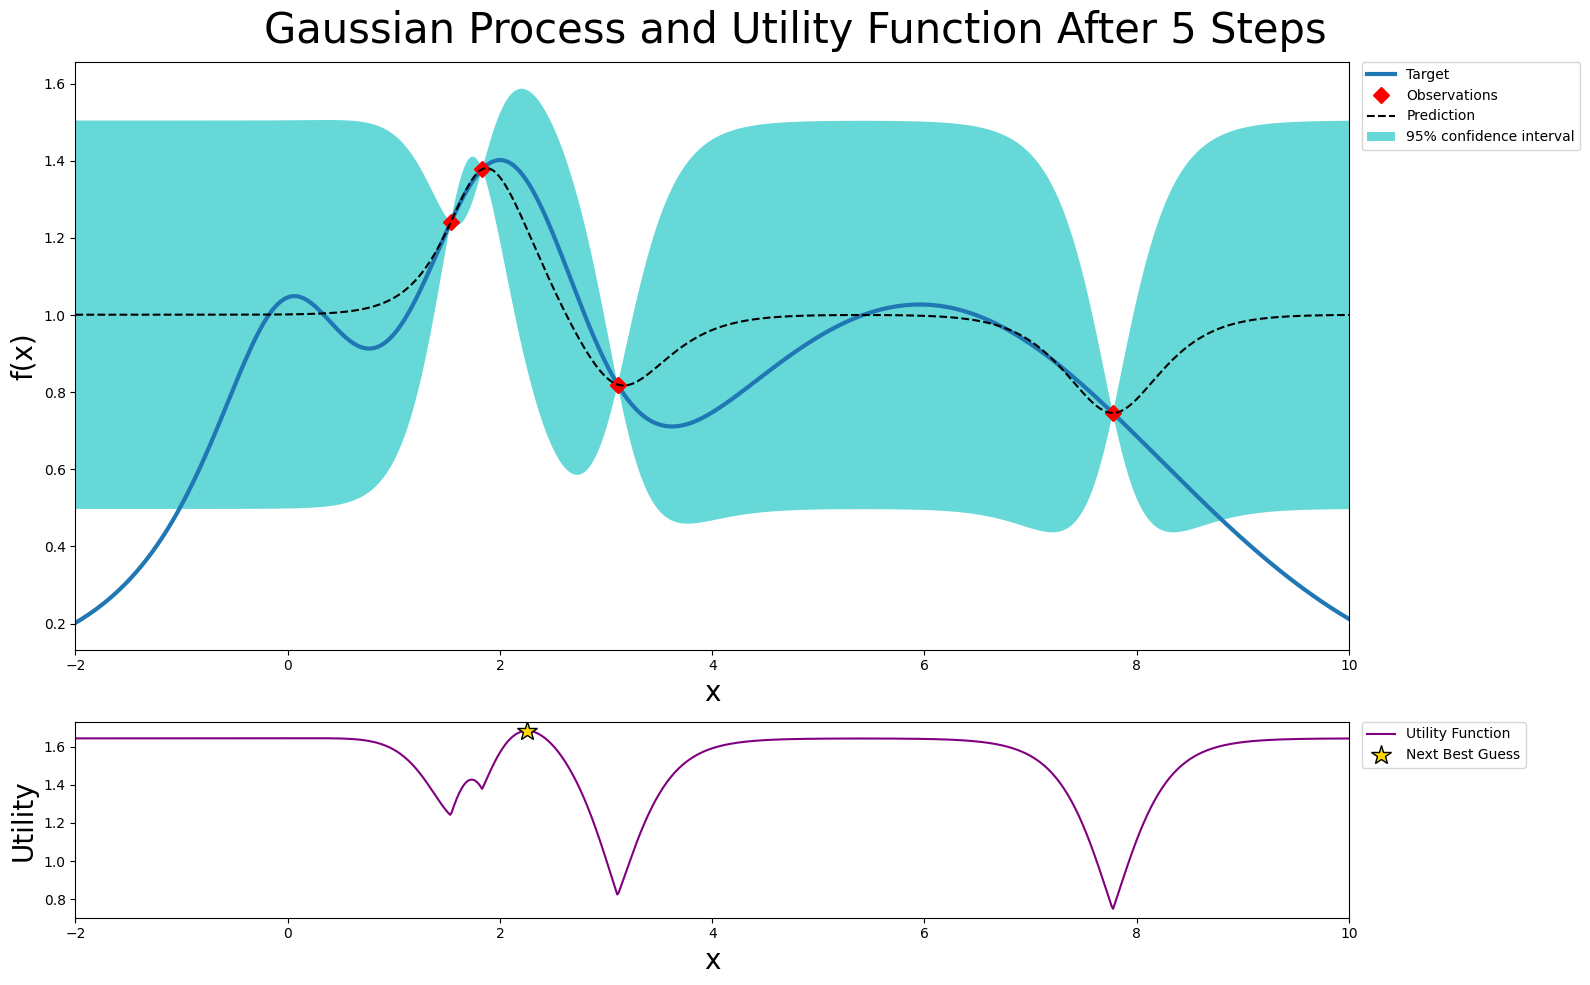

|   iter    |  target   |     x     |
-------------------------------------
| 6         | 1.347     | 2.257     |

Step 4: Added a new observation


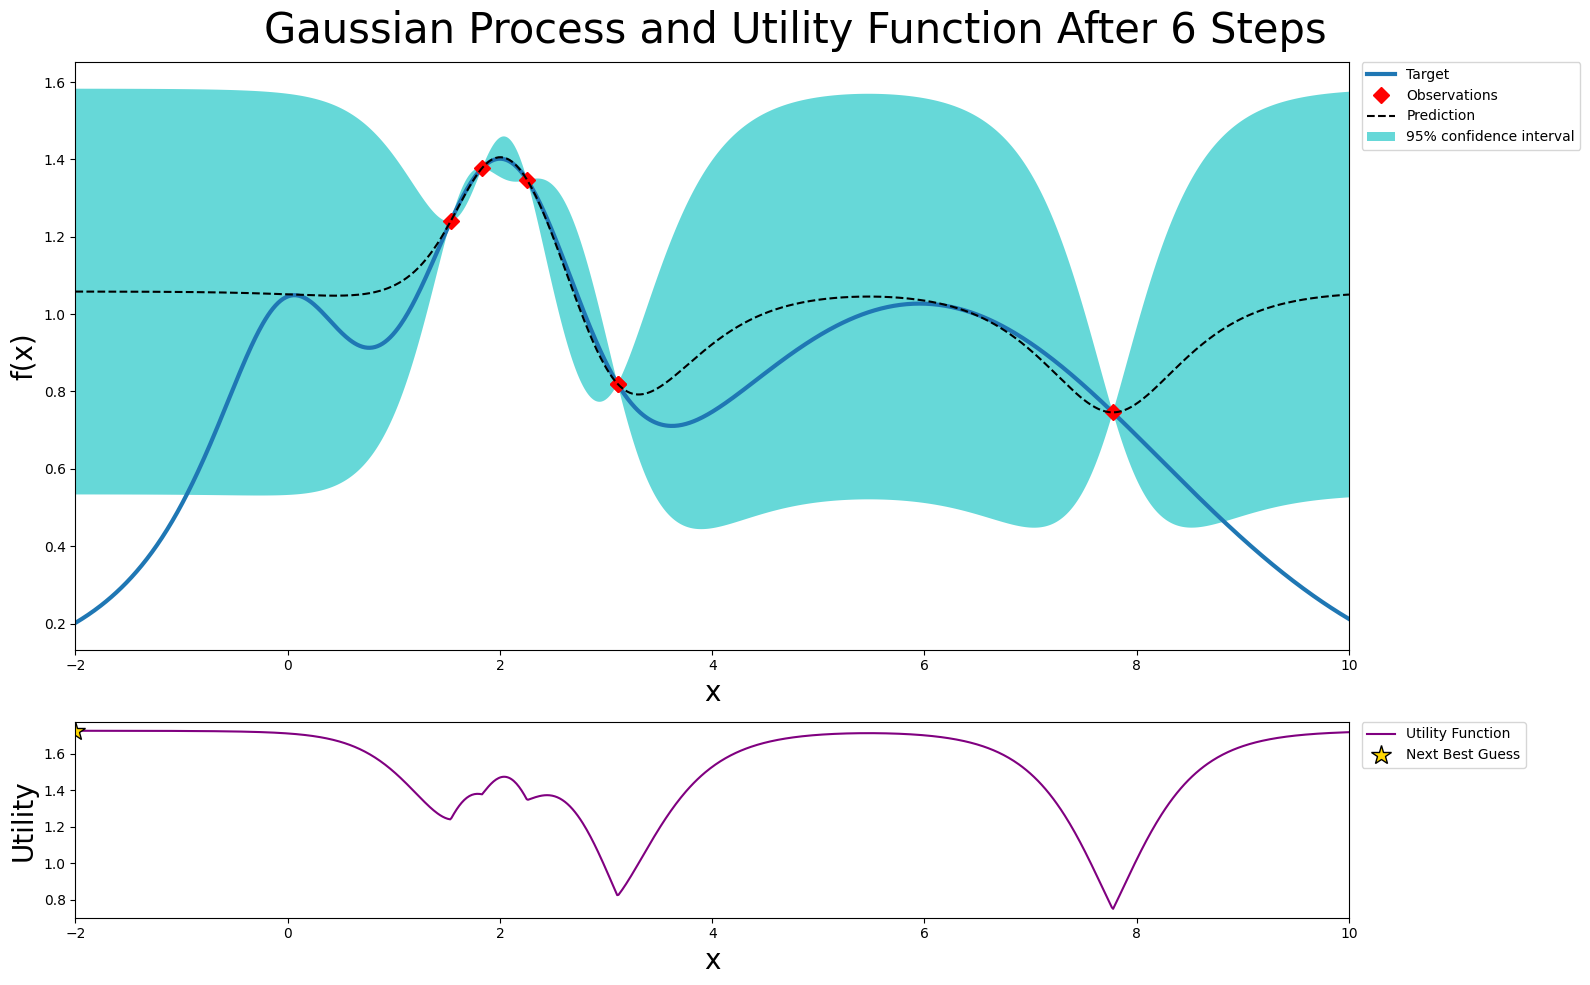

|   iter    |  target   |     x     |
-------------------------------------
| 7         | 0.2018    | -1.999    |

Step 5: Added a new observation


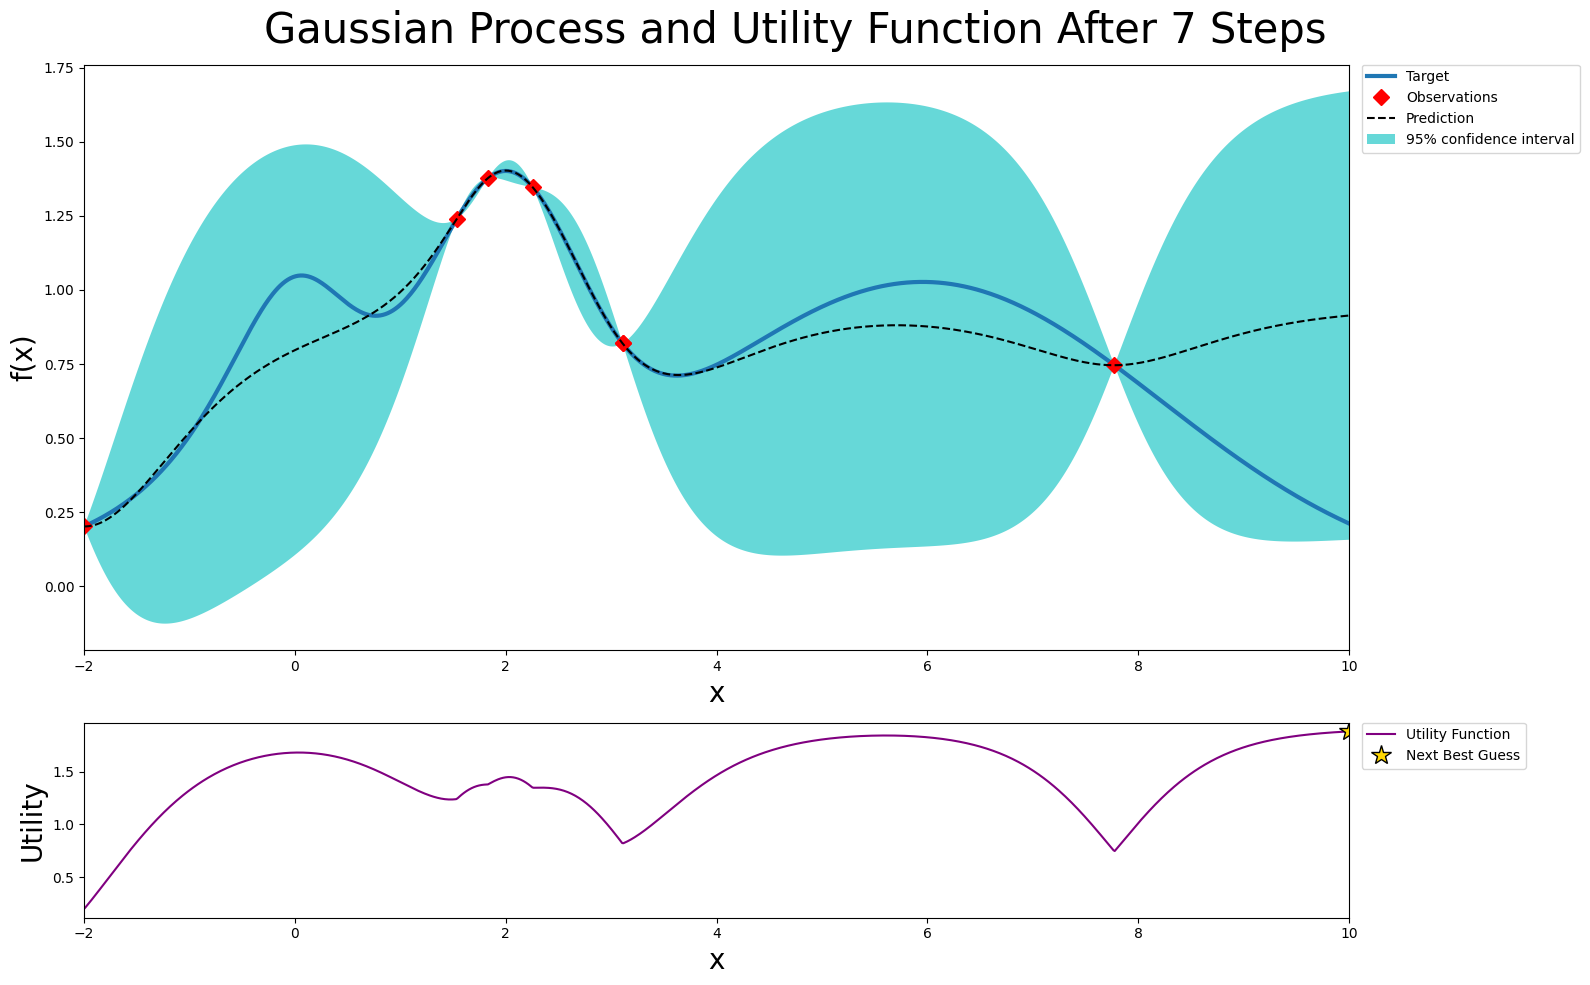


Final result:
Best target value found: 1.3779
Best input value found: x = 1.8325


In [5]:
acquisition_function = acquisition.UpperConfidenceBound(kappa=2.5)
optimizer = BayesianOptimization(
    f=target_function,
    pbounds={"x": (-2, 10)},
    acquisition_function=acquisition_function,
    random_state=27,
)

# Prepare data for visualization
x = np.linspace(-2, 10, 1000).reshape(-1, 1)
y = target_function(x)

# Initialize with 2 random points
optimizer.maximize(init_points=2, n_iter=0)
print("\nStep 0: Initial random points")
plot_gp(optimizer, x, y)

for i in range(1, 6):
    optimizer.maximize(init_points=0, n_iter=1)
    print(f"\nStep {i}: Added a new observation")
    plot_gp(optimizer, x, y)

print("\nFinal result:")
print(f"Best target value found: {optimizer.max['target']:.4f}")
print(f"Best input value found: x = {optimizer.max['params']['x']:.4f}")

Acquisition functions guide the sampling process by balancing:
- Exploitation: Sampling where the model predicts high values
- Exploration: Sampling where the model is uncertain

We'll compare three different acquisition functions:
1. Upper Confidence Bound (UCB): Balances exploration and exploitation
2. Probability of Improvement (PI): More exploitative
3. Greedy: Purely exploitative (custom implementation)

In [6]:
class GreedyAcquisition(acquisition.AcquisitionFunction):
    """Purely exploitative acquisition function (only considers mean)"""

    def __init__(self, random_state=None):
        super().__init__(random_state)

    def base_acq(self, mean: np.ndarray, std: np.ndarray) -> np.ndarray:
        return mean  # disregard std

|   iter    |  target   |     x     |
-------------------------------------
| 1         | 0.8198    | 3.109     |
| 2         | 0.746     | 7.775     |
| 3         | 0.9496    | 2.875     |
| 4         | 0.2022    | -1.997    |
| 5         | 1.398     | 2.072     |
| 6         | 0.9412    | 0.9708    |
| 7         | 0.2119    | 9.999     |

UCB Acquisition Function Results:


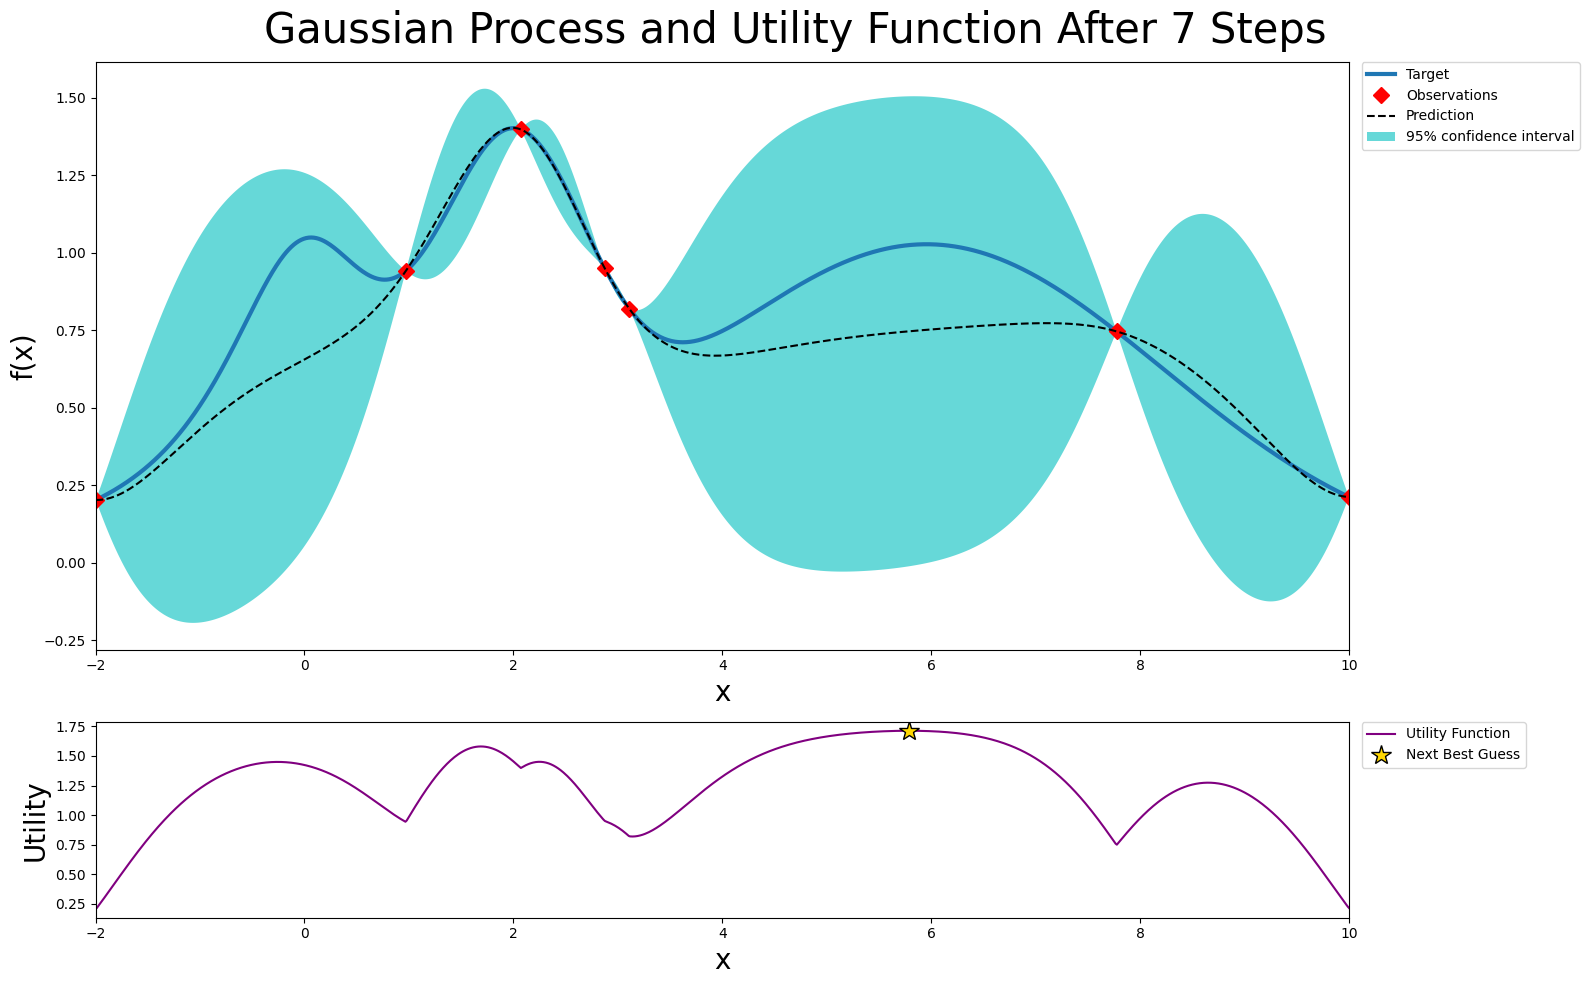

|   iter    |  target   |     x     |
-------------------------------------
| 1         | 0.8198    | 3.109     |
| 2         | 0.746     | 7.775     |
| 3         | 0.8155    | 3.118     |
| 4         | 0.8197    | 3.109     |
| 5         | 0.8206    | 3.107     |
| 6         | 0.822     | 3.104     |
| 7         | 0.8294    | 3.088     |

Probability of Improvement Acquisition Function Results:


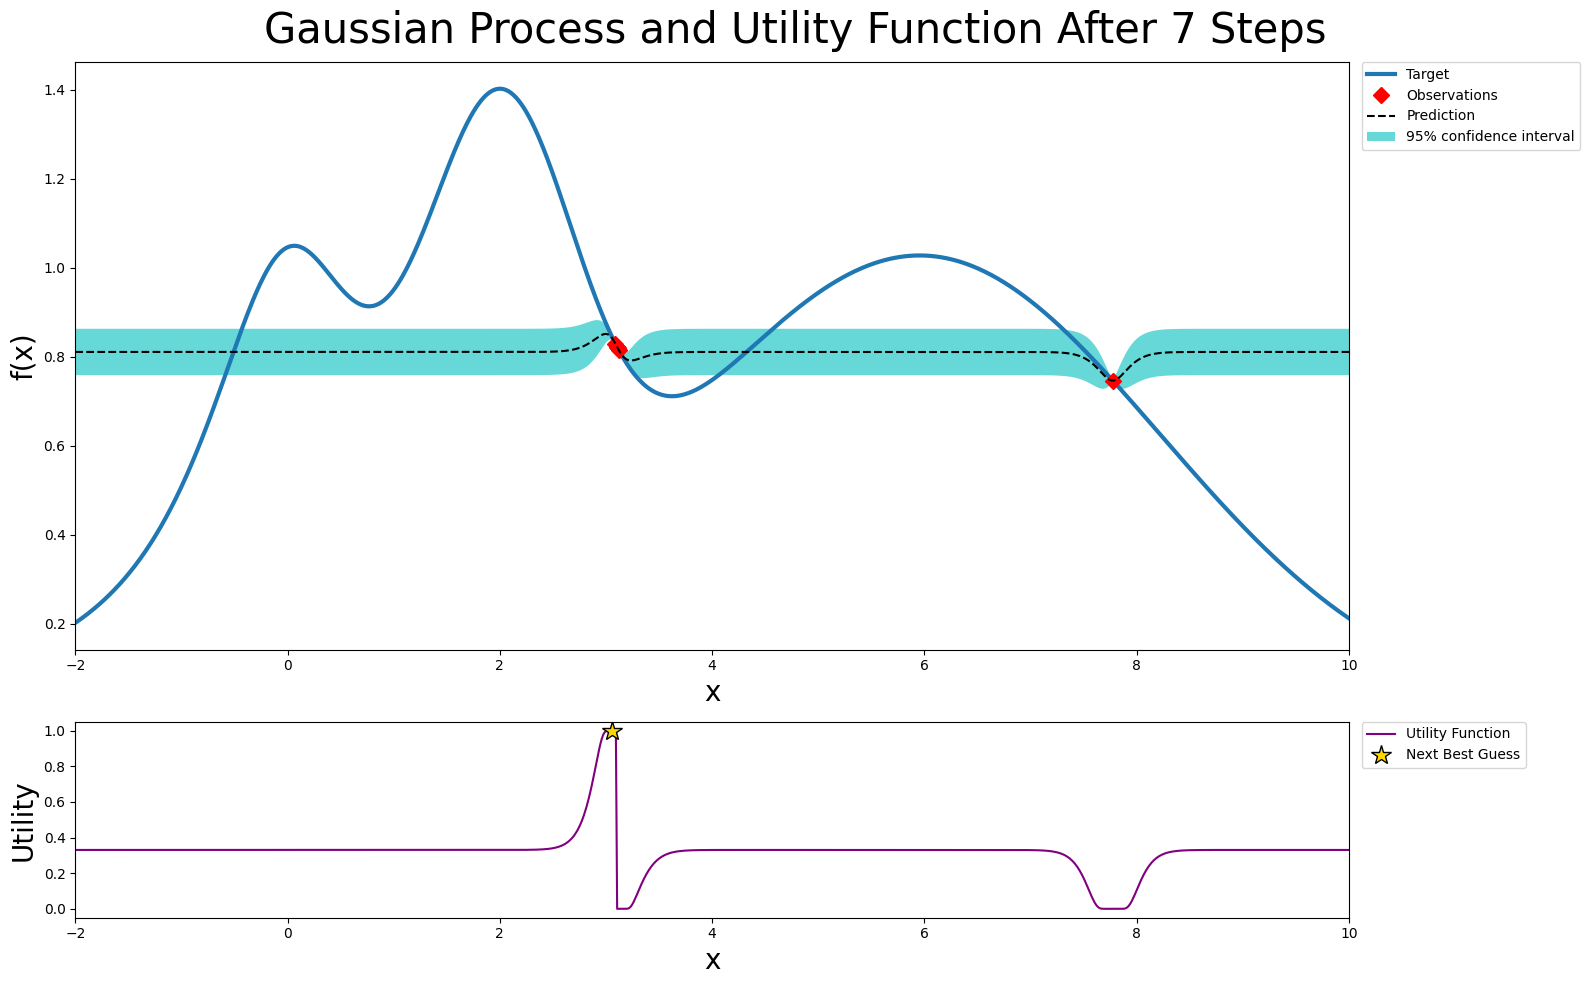

|   iter    |  target   |     x     |
-------------------------------------
| 1         | 0.8198    | 3.109     |
| 2         | 0.746     | 7.775     |
| 3         | 0.8196    | 3.109     |
| 4         | 0.8438    | 3.058     |
| 5         | 0.8722    | 3.004     |
| 6         | 0.9135    | 2.933     |
| 7         | 0.9738    | 2.838     |

Greedy (Purely Exploitative) Acquisition Function Results:


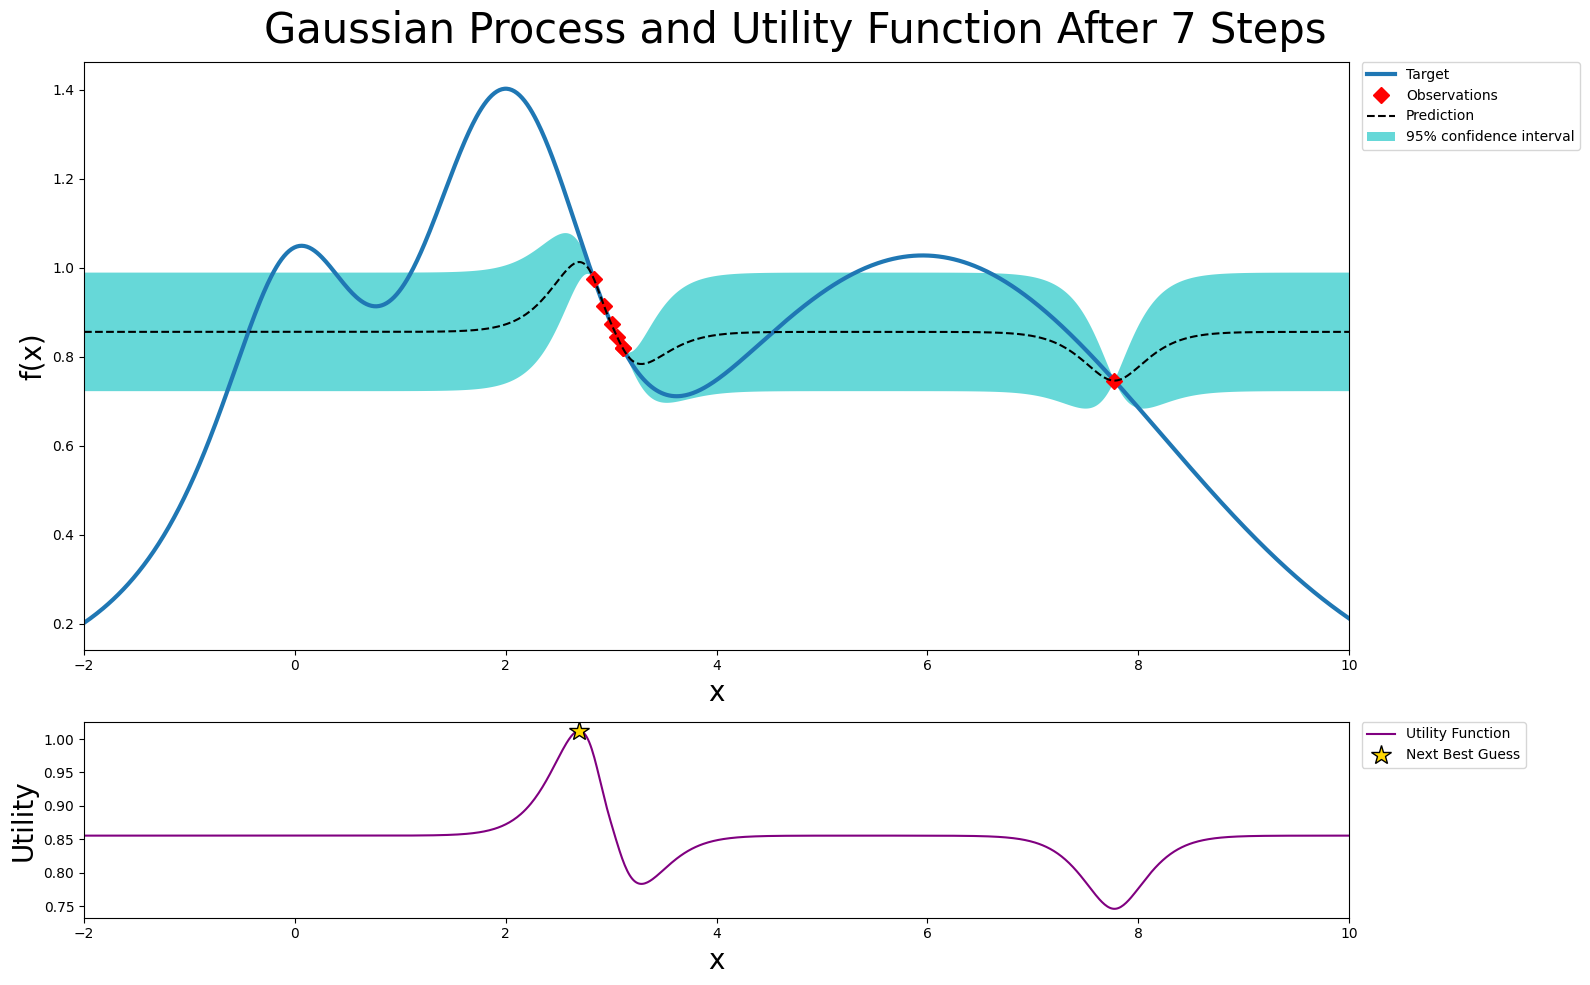


Summary of results:
UCB best value: 1.3976 at x = 2.0716
PI best value: 0.8294 at x = 3.0879
Greedy best value: 0.9738 at x = 2.8381


In [7]:
ucb = acquisition.UpperConfidenceBound(kappa=2.5)
optimizer_ucb = BayesianOptimization(
    f=target_function,
    pbounds={"x": (-2, 10)},
    acquisition_function=ucb,
    random_state=27,
)

optimizer_ucb.maximize(init_points=2, n_iter=5)
print("\nUCB Acquisition Function Results:")
plot_gp(optimizer_ucb, x, y)

# Run with PI
pi = acquisition.ProbabilityOfImprovement(xi=1e-4)
optimizer_pi = BayesianOptimization(
    f=target_function,
    pbounds={"x": (-2, 10)},
    acquisition_function=pi,
    random_state=27,
)

optimizer_pi.maximize(init_points=2, n_iter=5)
print("\nProbability of Improvement Acquisition Function Results:")
plot_gp(optimizer_pi, x, y)

# Run with Greedy
greedy = GreedyAcquisition()
optimizer_greedy = BayesianOptimization(
    f=target_function,
    pbounds={"x": (-2, 10)},
    acquisition_function=greedy,
    random_state=27,
)

optimizer_greedy.maximize(init_points=2, n_iter=5)
print("\nGreedy (Purely Exploitative) Acquisition Function Results:")
plot_gp(optimizer_greedy, x, y)

# Summary
print("\nSummary of results:")
print(
    f"UCB best value: {optimizer_ucb.max['target']:.4f} at x = {optimizer_ucb.max['params']['x']:.4f}"
)
print(
    f"PI best value: {optimizer_pi.max['target']:.4f} at x = {optimizer_pi.max['params']['x']:.4f}"
)
print(
    f"Greedy best value: {optimizer_greedy.max['target']:.4f} at x = {optimizer_greedy.max['params']['x']:.4f}"
)

Comment these results. Write your observations in a Markdown cell.

The USB yields the best results. It seems that the explorative approach pays off, since if
we have little observations it's only logical to search for better solutions. The greedy
acquisition function actually explores more than the PI one, yielding better results.

Exercise 1: UCB
---------------

The parameter kappa in the UCB acquisition function controls the trade-off between:
- Exploration (high kappa): More emphasis on the uncertainty
- Exploitation (low kappa): More emphasis on the predicted mean

Compare results for UCB using 3 different values:
1. kappa = 0.1 (Mostly exploitation)
2. kappa = 2.5 (Balanced)
3. kappa = 5.0 (Mostly exploration)

Review this [blog post](https://ekamperi.github.io/machine%20learning/2021/06/11/acquisition-functions.html) and explain the underlying concept of UCB in a Markdown cell.

|   iter    |  target   |     x     |
-------------------------------------
| 1         | 0.8198    | 3.109     |
| 2         | 0.746     | 7.775     |
| 3         | 0.8139    | 3.122     |
| 4         | 0.8201    | 3.108     |
| 5         | 0.8538    | 3.039     |
| 6         | 0.8875    | 2.977     |
| 7         | 0.9395    | 2.891     |
| 8         | 1.025     | 2.764     |
| 9         | 1.165     | 2.567     |
Best result for kappa 0.1: 1.1646


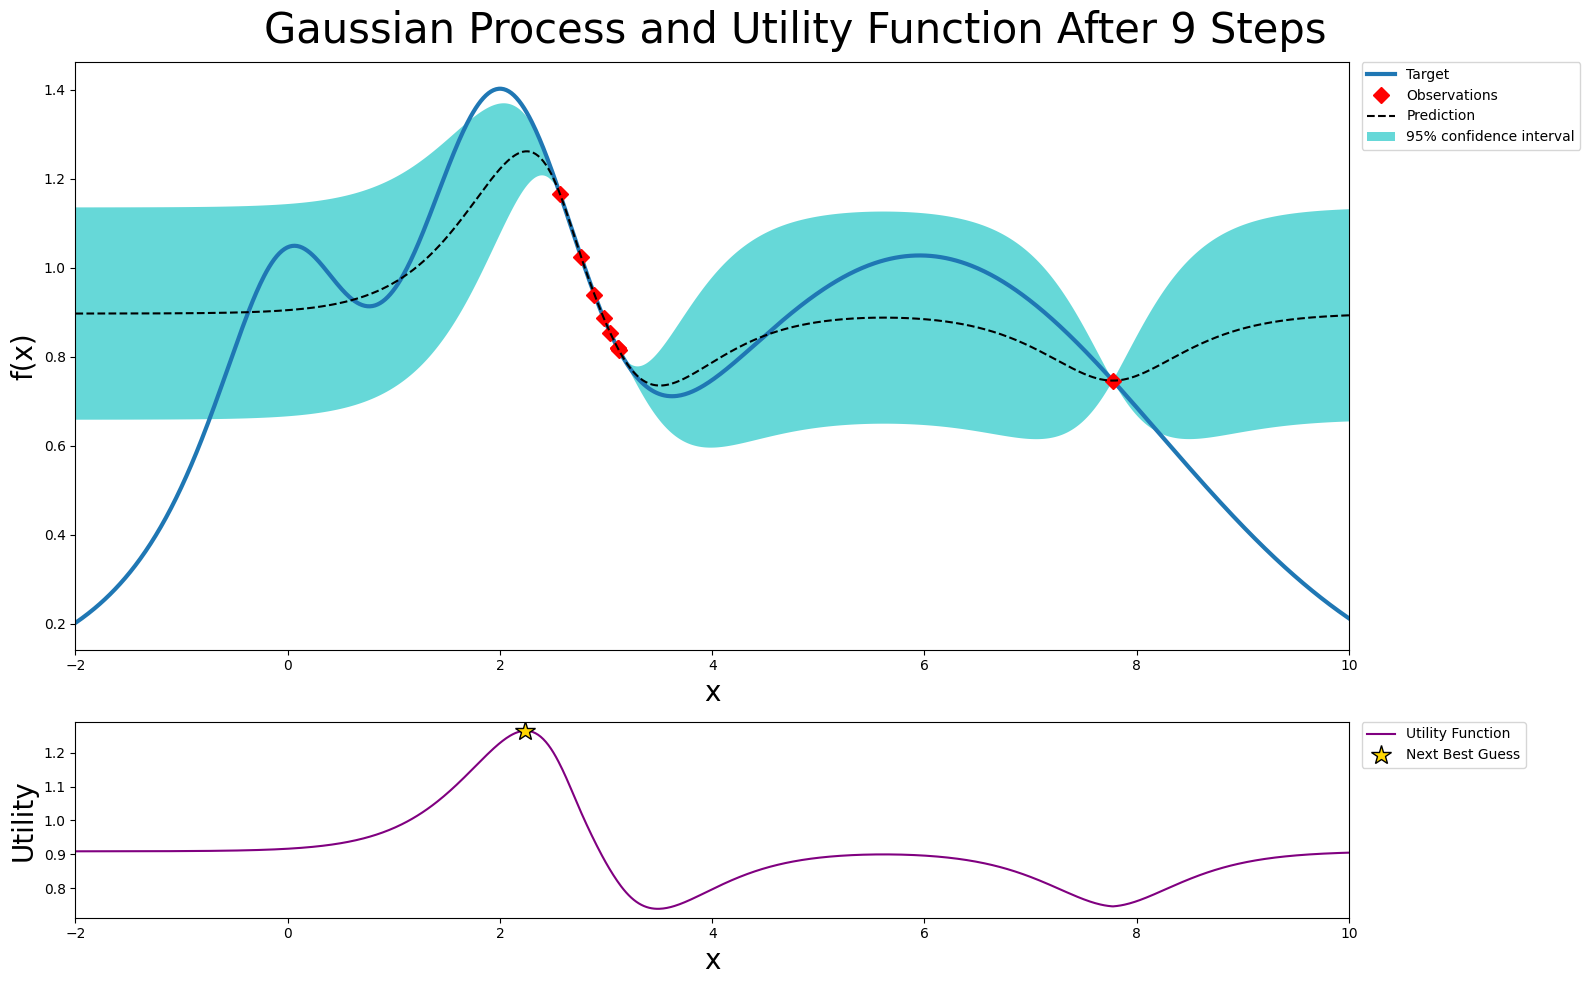

|   iter    |  target   |     x     |
-------------------------------------
| 1         | 0.8198    | 3.109     |
| 2         | 0.746     | 7.775     |
| 3         | 0.7407    | 3.342     |
| 4         | 1.007     | 6.415     |
| 5         | 1.007     | 6.415     |
| 6         | 1.024     | 5.774     |
| 7         | 0.9511    | 5.047     |
| 8         | 1.379     | 1.836     |
| 9         | 0.973     | 1.064     |
Best result for kappa 2.5: 1.3788


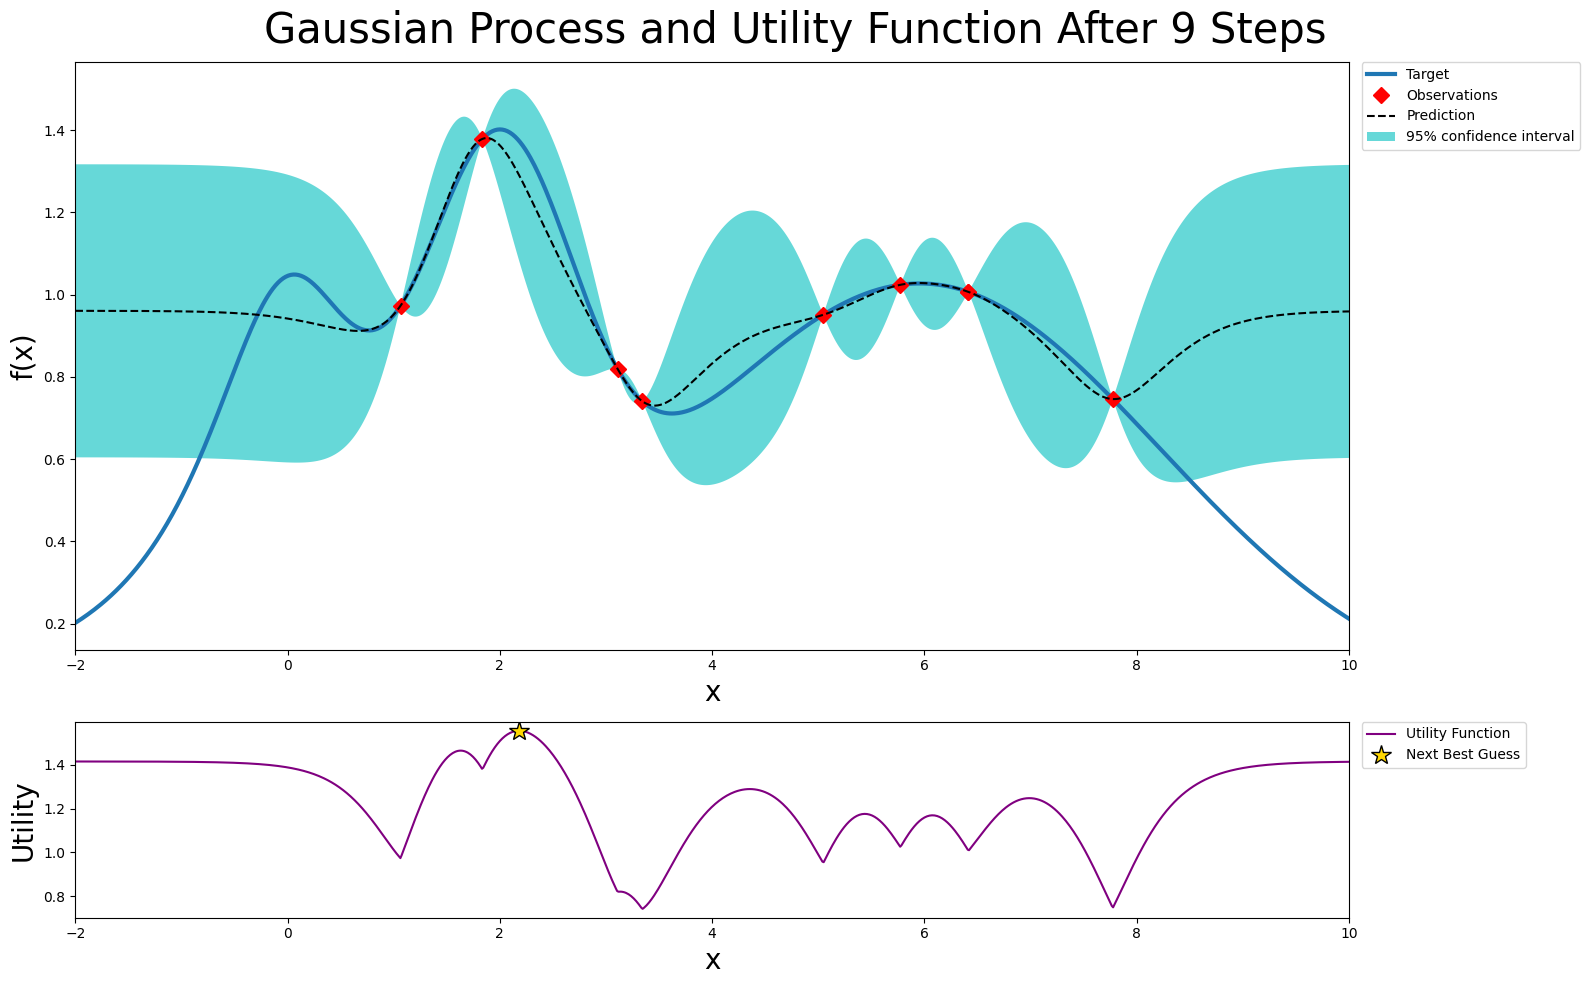

|   iter    |  target   |     x     |
-------------------------------------
| 1         | 0.8198    | 3.109     |
| 2         | 0.746     | 7.775     |
| 3         | 1.007     | 2.79      |
| 4         | 0.8804    | 4.659     |
| 5         | 1.366     | 2.205     |
| 6         | 1.357     | 2.229     |
| 7         | 1.006     | 0.3223    |
| 8         | 0.2019    | -1.999    |
| 9         | 0.212     | 9.999     |
Best result for kappa 5.0: 1.3664


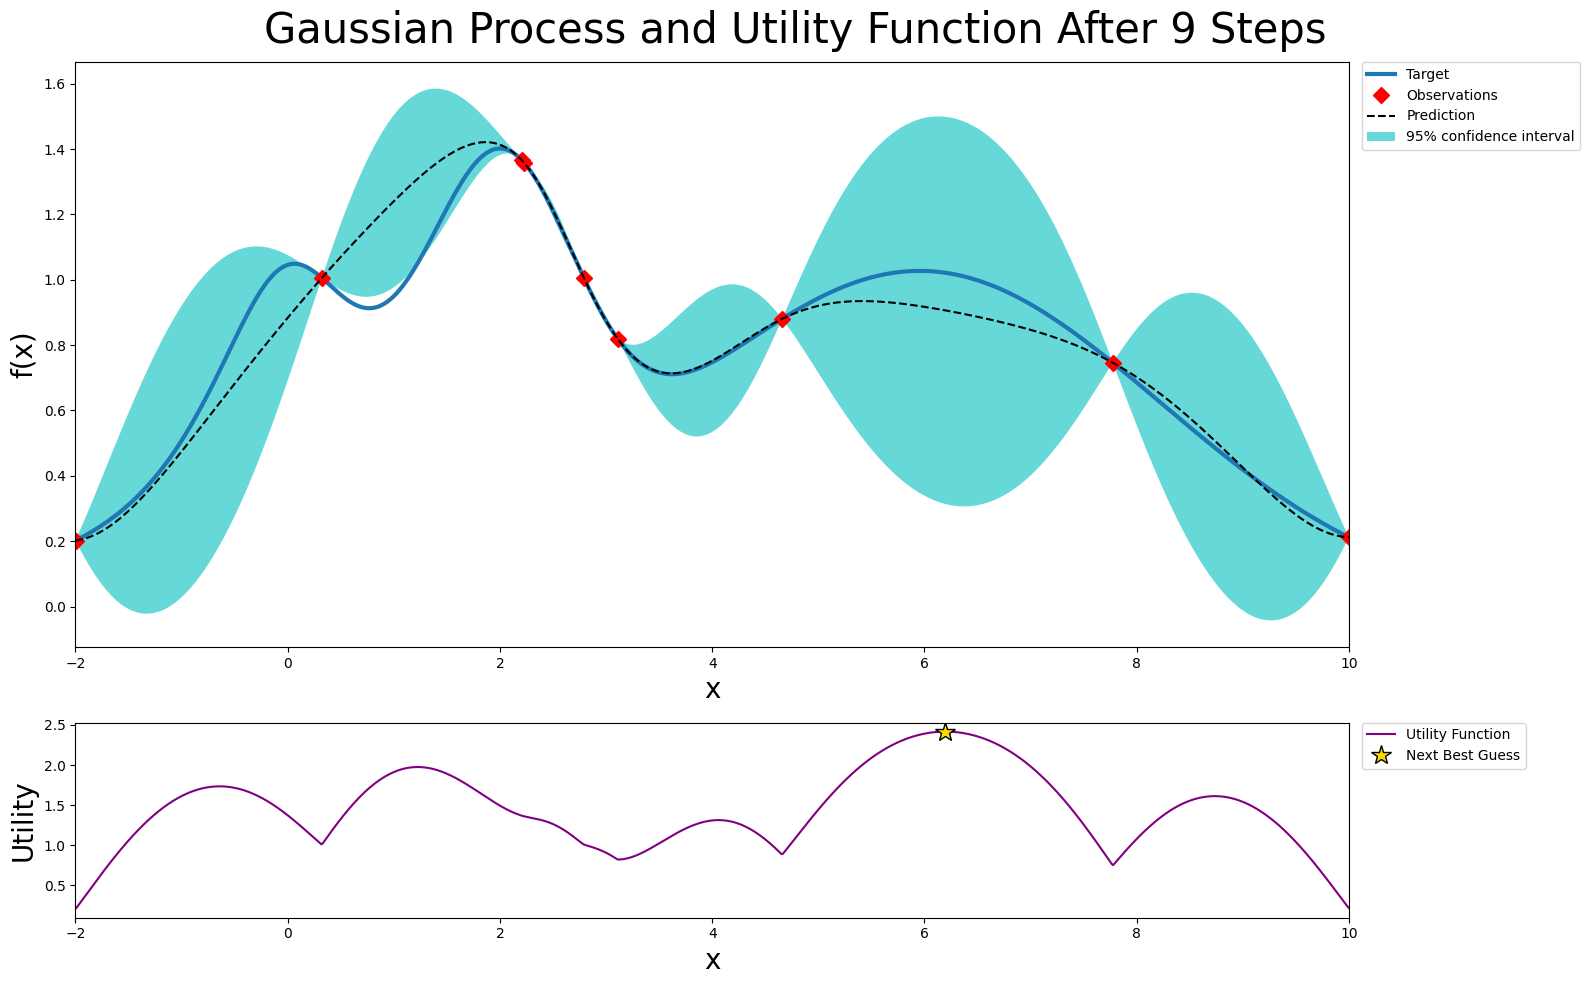

In [8]:
for kappa in [0.1, 2.5, 5.0]:
    ucb = acquisition.UpperConfidenceBound(kappa=kappa)
    optimizer = BayesianOptimization(
        f=target_function,
        pbounds={"x": (-2, 10)},
        acquisition_function=ucb,
        random_state=27,
    )
    optimizer.maximize(init_points=2, n_iter=7)
    print(f"Best result for kappa {kappa}: {optimizer.max['target']:.4f}")
    plot_gp(optimizer, x, y)

The UCB is a really simple acquisition function that is nothing more than a sum of mean and std 
multiplied by a coefficient. This coefficient is used to regulate the exploration exploitation
tradeoff

Exercise 2: Chaotic Acquisition Function
-----------------------------------------
**Goal**: Implement a chaotic acquisition function that exclusively prioritizes the standard deviation of predictions, disregarding the predicted mean. Compare its performance against standard acquisition functions such as UCB and PI (Probability of Improvement).

In [9]:
class ChaoticAcquisition(acquisition.AcquisitionFunction):
    def __init__(self, random_state=None):
        super().__init__(random_state)

    def base_acq(self, mean: np.ndarray, std: np.ndarray) -> np.ndarray:
        return std

|   iter    |  target   |     x     |
-------------------------------------
| 1         | 0.8198    | 3.109     |
| 2         | 0.746     | 7.775     |
| 3         | 0.7406    | 3.343     |
| 4         | 0.9357    | 2.897     |
| 5         | 0.9357    | 2.897     |
| 6         | 1.143     | 2.598     |
| 7         | 1.372     | 2.186     |

UCB Acquisition Function Results:


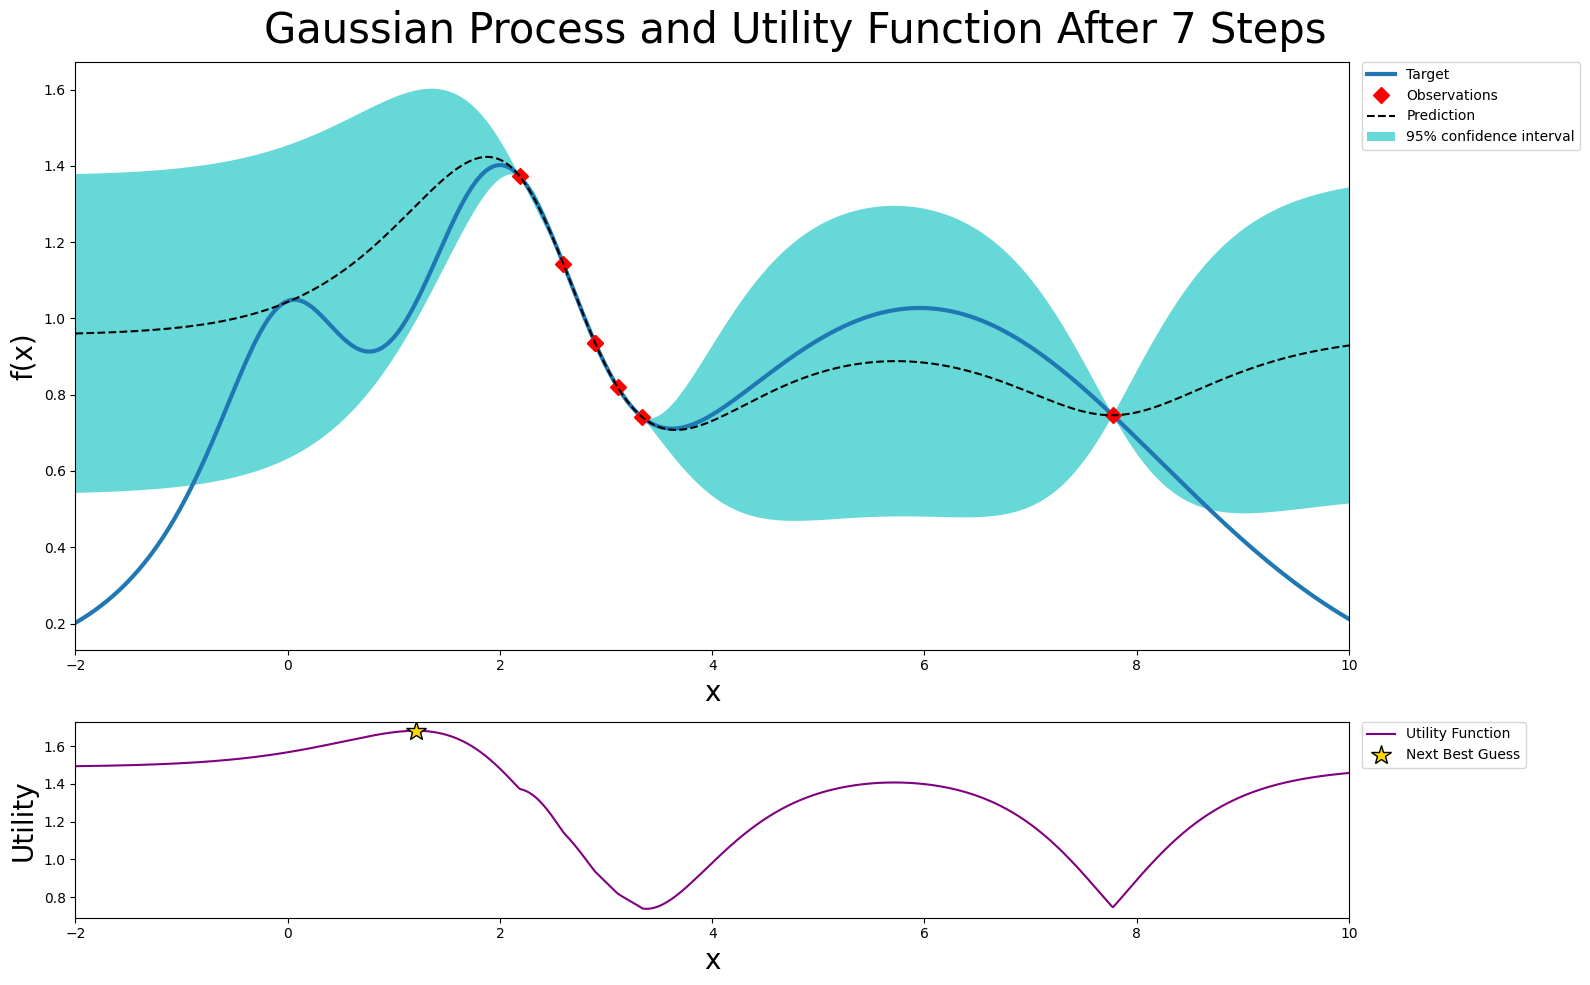

|   iter    |  target   |     x     |
-------------------------------------
| 1         | 0.8198    | 3.109     |
| 2         | 0.746     | 7.775     |
| 3         | 1.003     | 5.451     |
| 4         | 1.135     | 1.367     |
| 5         | 0.9416    | 0.5484    |
| 6         | 0.7233    | -0.6388   |
| 7         | 0.212     | 9.999     |

Probability of Improvement Acquisition Function Results:


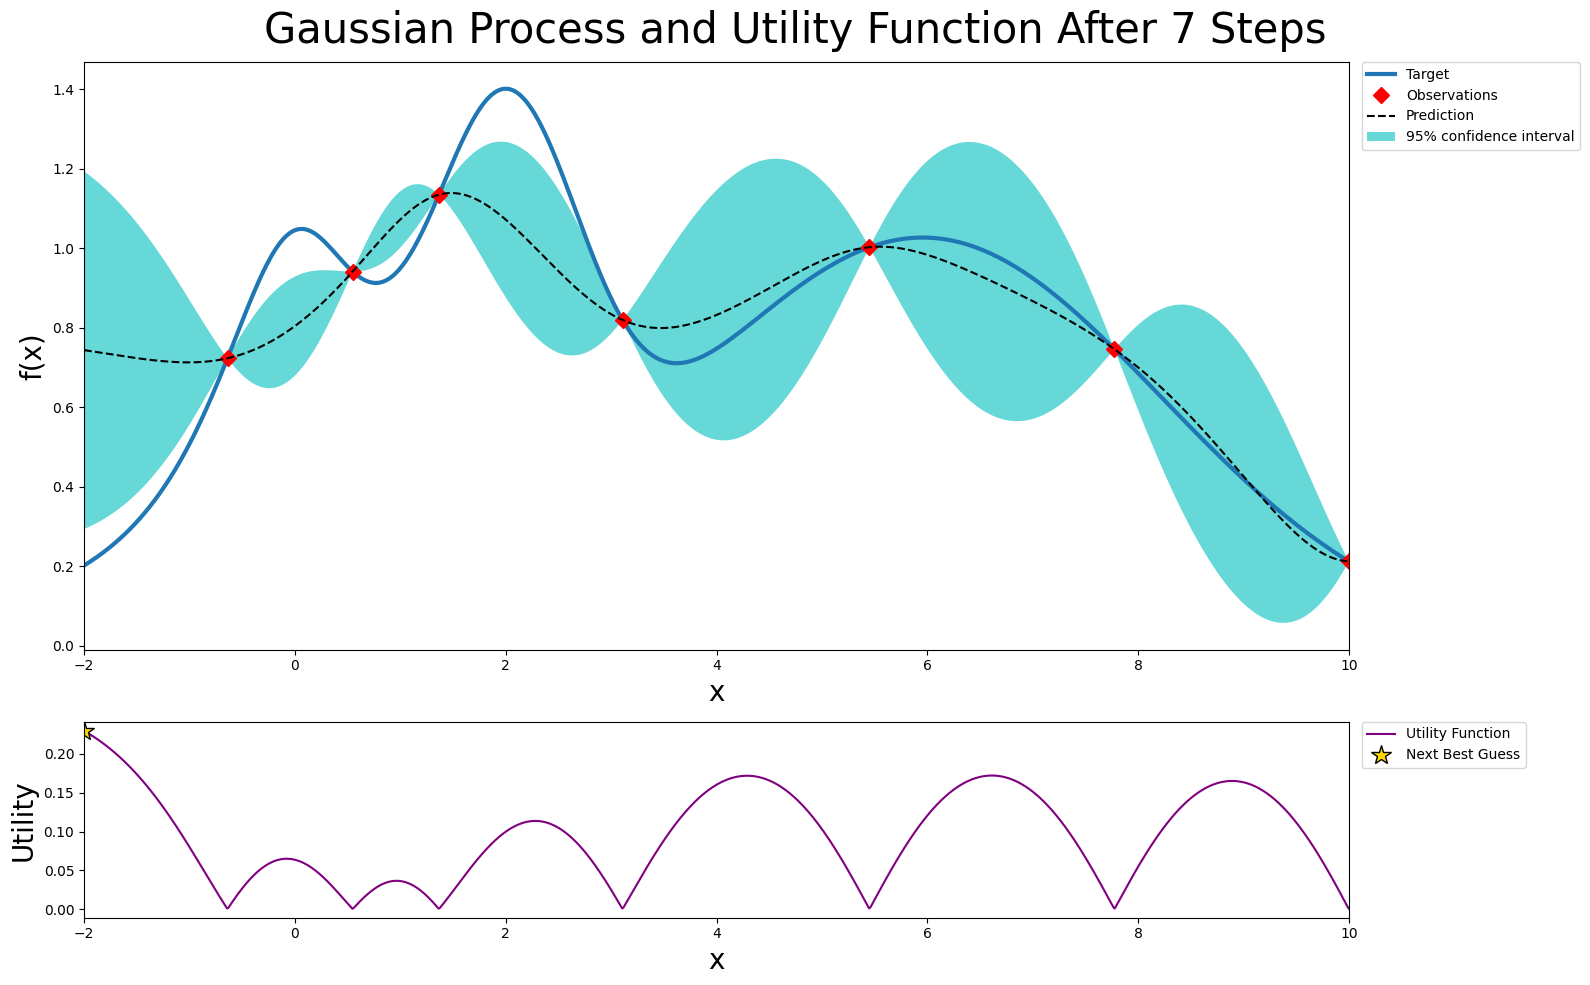

1

In [22]:
ucb = acquisition.UpperConfidenceBound(kappa=2.5)
optimizer_ucb = BayesianOptimization(
    f=target_function,
    pbounds={"x": (-2, 10)},
    acquisition_function=ucb,
    random_state=27,
)

optimizer_ucb.maximize(init_points=2, n_iter=5)
print("\nUCB Acquisition Function Results:")
plot_gp(optimizer_ucb, x, y)

# Run with Chaotic
chaotic = ChaoticAcquisition()
optimizer_chaotic = BayesianOptimization(
    f=target_function,
    pbounds={"x": (-2, 10)},
    acquisition_function=chaotic,
    random_state=27,
)

optimizer_chaotic.maximize(init_points=2, n_iter=5)
print("\nProbability of Improvement Acquisition Function Results:")
plot_gp(optimizer_chaotic, x, y)
1

The function is fully focused on the exploration aspect, since it probes the least known areas.
This can be beneficial for some functions especially in the early phases, but fades off later on
when we have enough data to make informed decisions worthwhile.

Exercise 3: Expected Improvement
--------------------------------

**Goal:** Implement the Expected Improvement (EI) acquisition function by extending the `AcquisitionFunction` base class provided by the `BayesOpt` library.

Expected Improvement (EI) is a popular choice for the acquisition function. Let's understand its derivation:

1.  **Current Best:** After $n$ evaluations, the best function value observed *so far* is $f^* = \max_{m=1..n} f(x_m)$.

2.  **Potential Improvement:** If we evaluate a new point $x$, the *actual* improvement over the current best $f^*$ is $\max(f(x) - f^*, 0)$, sometimes written as $[f(x) - f^*]^+$.

3.  **The Challenge:** We want to choose $x$ to maximize this improvement, but $f(x)$ is unknown *before* evaluation.

4.  **The Solution: Expected Improvement:** Our probabilistic model gives a posterior distribution for $f(x)$ at any point $x$. Given the data, this is typically a Gaussian distribution: $f(x) \sim \mathcal{N}(\mu_n(x), \sigma_n^2(x))$. EI maximizes the *expected* value of the improvement, where the expectation is taken over this posterior distribution:

    $EI_n(x) = E_n[ \max(f(x) - f^*, 0) ]$

    This value represents, on average, how much we expect to improve upon $f^*$ by evaluating at $x$. The next point chosen is the one that maximizes $EI_n(x)$.

### Mathematical Formulation

The expected improvement integral can be computed analytically. The standard closed-form expression is:

$$
EI(x) =
\begin{cases}
(\mu(x) - f^*) \Phi(Z) + \sigma(x) \varphi(Z) & \text{if } \sigma(x) > 0 \\
0 & \text{if } \sigma(x) = 0
\end{cases}
$$

Where:

* $\mu(x)$: The posterior mean of $f(x)$ at point $x$.
* $\sigma(x)$: The posterior standard deviation of $f(x)$ at point $x$.
* $f^*$: The best function value observed so far (a single scalar value).
* $Z = \frac{\mu(x) - f^*}{\sigma(x)}$
* $\Phi(Z)$: The Cumulative Distribution Function (CDF) of the standard normal distribution $\mathcal{N}(0, 1)$.
* $\varphi(Z)$: The Probability Density Function (PDF) of the standard normal distribution $\mathcal{N}(0, 1)$.

### Implementation Task

Create a class `ExpectedImprovement` inheriting from `acquisition.AcquisitionFunction` and implement the core calculation in the `base_acq` method. The signature of `base_acq` method looks like this:
```python
def base_acq(self, mean: NDArray[Float], std: NDArray[Float]) -> NDArray[Float]:
```

Compare its performance against other acquisition functions.

Hint: Analyse the source code of `UpperConfidenceBound` class to better understand how to use/update $f^*$ (`self.y_max`).

In [18]:
from scipy.stats import norm

class ExpectedImprovement(acquisition.AcquisitionFunction):
    def __init__(self, random_state=None):
        super().__init__(random_state)
        self.y_max = None

    def base_acq(self, mean: np.ndarray, std: np.ndarray) -> np.ndarray:
        if (std == 0.0).all():
            return std
        else:
            z = (mean - self.y_max) / std
            ei = (mean - self.y_max) * norm.cdf(z, loc=0, scale=1) + std * norm.pdf(z, loc=0, scale=1)
            return ei

    def suggest(
            self,
            gp,
            target_space,
            n_random: int = 10_000,
            n_l_bfgs_b: int = 10,
            fit_gp: bool = True,
    ):
        """Suggest a promising point to probe next.

        Parameters
        ----------
        gp : GaussianProcessRegressor
            A fitted Gaussian Process.

        target_space : TargetSpace
            The target space to probe.

        n_random : int, default 10_000
            Number of random samples to use.

        n_l_bfgs_b : int, default 10
            Number of starting points for the L-BFGS-B optimizer.

        fit_gp : bool, default True
            Whether to fit the Gaussian Process to the target space.
            Set to False if the GP is already fitted.

        Returns
        -------
        np.ndarray
            Suggested point to probe next.
        """
        y_max = target_space._target_max()
        if y_max is None and not target_space.empty:
            # If target space is empty, let base class handle the error
            msg = (
                "Cannot suggest a point without an allowed point. Use "
                "target_space.random_sample() to generate a point until "
                " at least one point that satisfies the constraints is found."
            )
            raise msg
        self.y_max = y_max
        x_max = super().suggest(
            gp=gp, target_space=target_space, n_random=n_random, n_l_bfgs_b=n_l_bfgs_b, fit_gp=fit_gp
        )
        return x_max


|   iter    |  target   |     x     |
-------------------------------------
| 1         | 0.8198    | 3.109     |
| 2         | 0.746     | 7.775     |
| 3         | 0.7397    | 3.346     |
| 4         | 1.049     | 0.08049   |
| 5         | 0.9629    | 0.4679    |
| 6         | 0.847     | -0.4541   |
| 7         | 0.4924    | 8.712     |

UCB Acquisition Function Results:


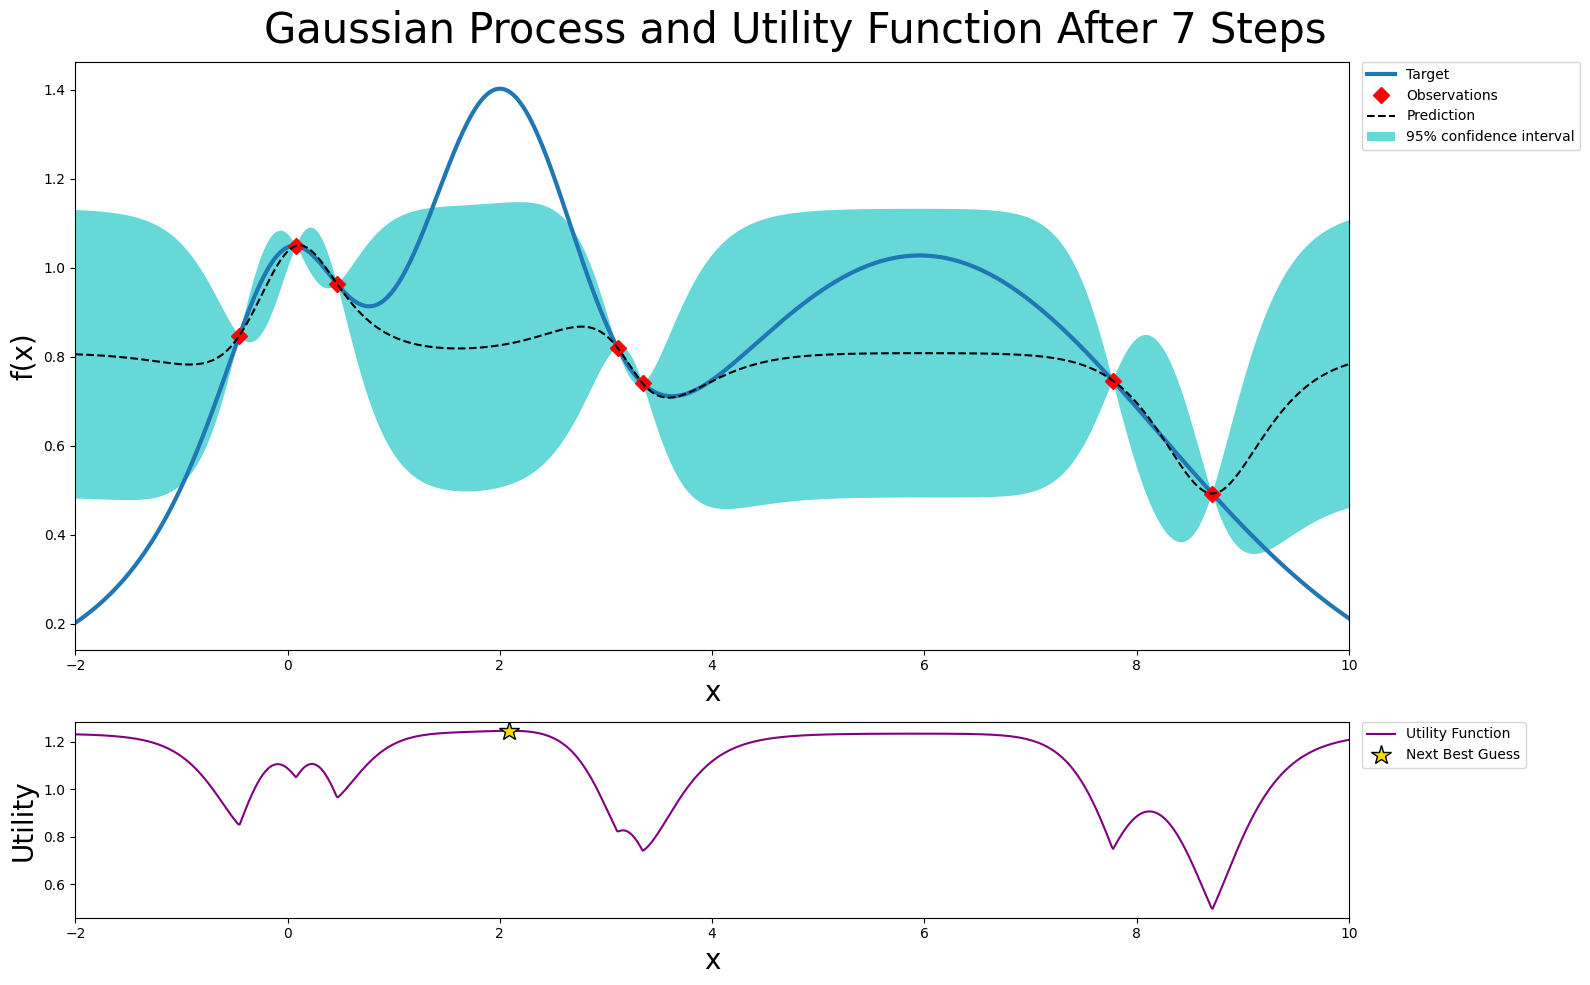

|   iter    |  target   |     x     |
-------------------------------------
| 1         | 0.8198    | 3.109     |
| 2         | 0.746     | 7.775     |
| 3         | 0.8894    | 2.973     |
| 4         | 0.7472    | 3.315     |
| 5         | 0.8301    | -0.4797   |
| 6         | 0.9305    | 2.905     |
| 7         | 1.001     | 2.798     |

Expected Improvement Acquisition Function Results:


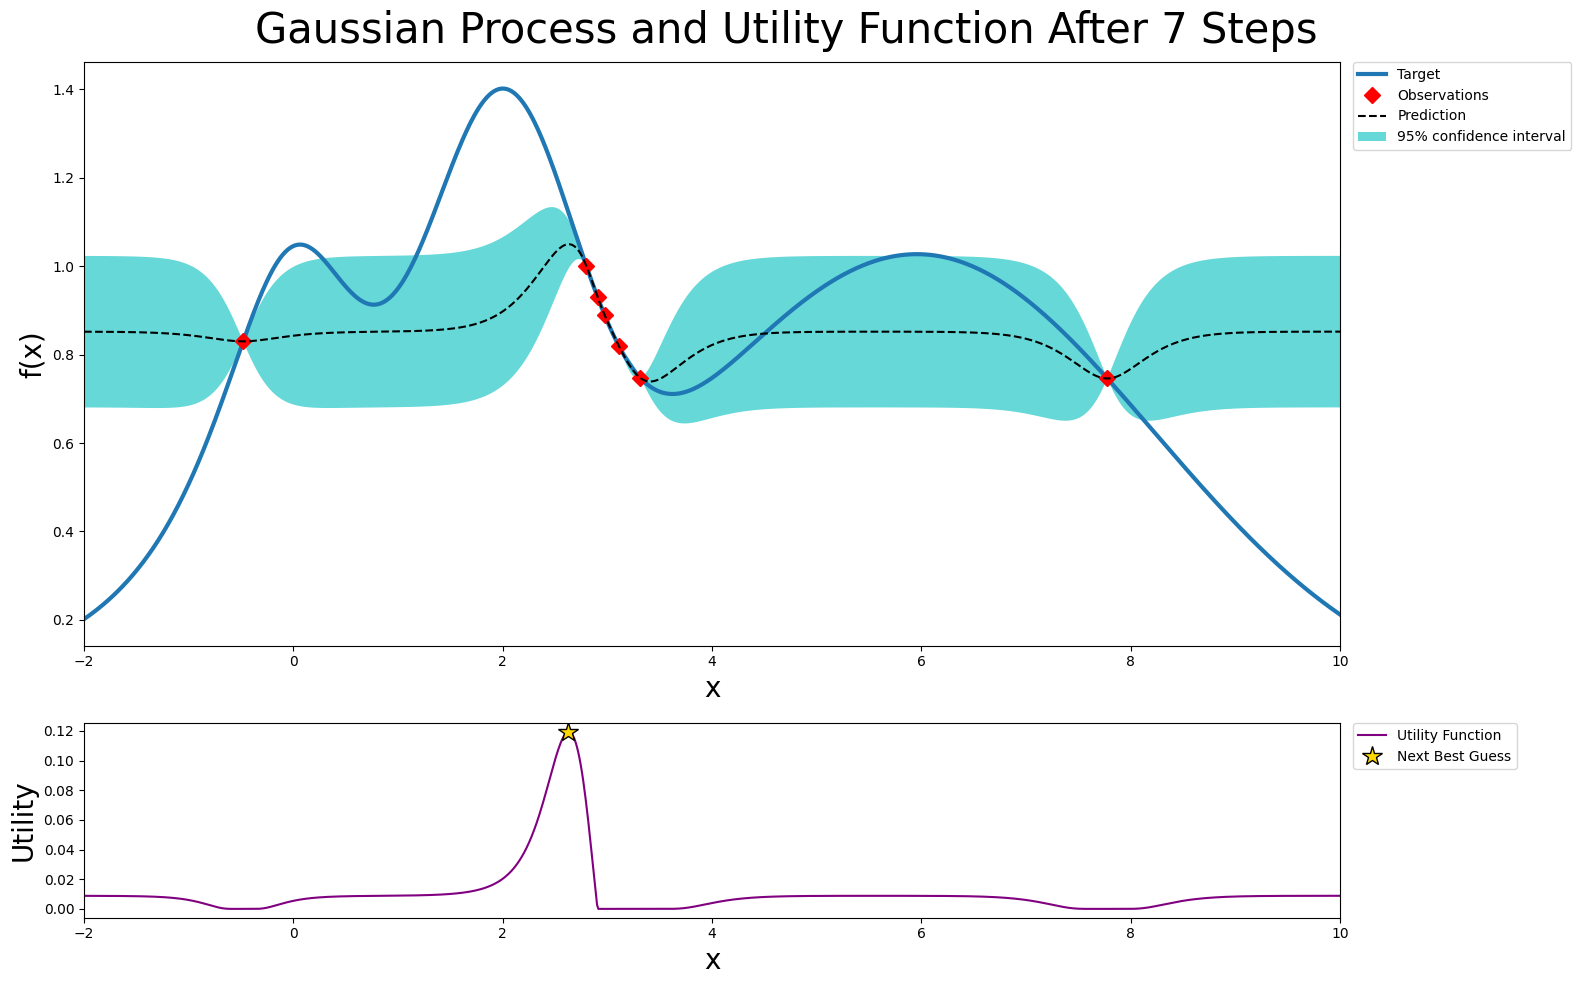

1

In [21]:
ucb = acquisition.UpperConfidenceBound()
optimizer_ucb = BayesianOptimization(
    f=target_function,
    pbounds={"x": (-2, 10)},
    acquisition_function=ucb,
    random_state=27,
)

optimizer_ucb.maximize(init_points=2, n_iter=5)
print("\nUCB Acquisition Function Results:")
plot_gp(optimizer_ucb, x, y)

# Run with EI
ei = ExpectedImprovement()
optimizer_ei = BayesianOptimization(
    f=target_function,
    pbounds={"x": (-2, 10)},
    acquisition_function=ei,
    random_state=27,
)

optimizer_ei.maximize(init_points=2, n_iter=5)
print("\nExpected Improvement Acquisition Function Results:")
plot_gp(optimizer_ei, x, y)
1


Exercise 4: Theoretical Questions
--------------------------------
1. Why is Bayesian Optimization particularly useful for expensive-to-evaluate functions?
2. Compare and contrast the different acquisition functions discussed in this tutorial.
3. What are the limitations of Bayesian Optimization?

1. The reason is really simple, it can provide accurate and insightful results even for use cases where we don't have a lot of data, or it's acquisition is expensive.
2. The most notable differences are in regard to exploration-exploitation tradeoff, functions like UCB provide a way to regulate it, where other ones, like the chaotic one, have some balance built in.
3. In some cases bayesian optimization can prove a suboptimal tool for the job. It can be too expensive, hyperparameter tuning is difficult, etc.